# Is there a link between ME genotype and gene expression?

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy.stats import permutation_test, false_discovery_control, spearmanr
import pybedtools

from warnings import filterwarnings
filterwarnings("ignore", category=pd.errors.DtypeWarning)
filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Filter annotations

In [11]:
path = '/cndd3/dburrows/DATA/annotations/gencode/'

In [18]:
%%bash
#Get bed file with gene names
#==================================
cd /cndd3/dburrows/DATA/annotations/gencode/
#Split up 4th column into gene id and type
# awk 'BEGIN{OFS="\t"} {split($4, a, "_"); $4 = a[1]; $5 = a[2]; print}' gencode.v44.annotation.hg38.genelabels.bed > tmp_split.bed
# mv tmp_split.bed gencode.v44.annotation.hg38.genelabels.bed

#remove duplicated gene loci (exons from isoforms) that have the same chromosome, start+end position gene_label, and strand
# awk '!seen[$1,$2,$3,$5,$6]++' gencode.v44.annotation.hg38.genelabels.bed > tmp_seen.bed
# mv tmp_seen.bed gencode.v44.annotation.hg38.genelabels.unique.bed
awk -F'\t' '{
    # Extract necessary fields from the 9th column (attributes)
    match($9, /gene_id=([^;]+)/, gene_id);
    match($9, /gene_name=([^;]+)/, gene_name);
    match($9, /gene_type=([^;]+)/, gene_type);

    # Rearrange and print the columns
    print $1, $4, $5, $2, $3, $7, gene_id[1], gene_name[1], gene_type[1];
}' OFS="\t" gencode.v46.basic.annotation.sorted.genes.gff3 > gencode.v46.basic.annotation.sorted.genes.bed

In [15]:
# %%bash
# #extract exons
# #=====================
# cd /cndd3/dburrows/DATA/annotations/gencode/
# # zcat gencode.v46.annotation.gff3.gz | awk '$3 == "exon"' > gencode.v46.annotation.exons_only.gff3

# awk -F'\t' '{
#     # Extract necessary fields from the 9th column (attributes)
#     match($9, /gene_id=([^;]+)/, gene_id);
#     match($9, /gene_name=([^;]+)/, gene_name);
#     match($9, /gene_type=([^;]+)/, gene_type);

#     # Rearrange and print the columns
#     print $1, $4, $5, $2, $3, $7, gene_id[1], gene_name[1], gene_type[1];
# }' OFS="\t" gencode.v46.annotation.exons_only.gff3 > gencode.v46.annotation.exons_only.bed

exon_df = pd.read_csv(path + 'gencode.v46.annotation.exons_only.bed', sep='\t', header=None)
exon_df

,0,1,2,3,4,5,6,7,8
0,chr1,11869,12227,HAVANA,exon,+,ENSG00000290825.1,DDX11L2,lncRNA
1,chr1,12613,12721,HAVANA,exon,+,ENSG00000290825.1,DDX11L2,lncRNA
2,chr1,13221,14409,HAVANA,exon,+,ENSG00000290825.1,DDX11L2,lncRNA
3,chr1,12010,12057,HAVANA,exon,+,ENSG00000223972.6,DDX11L1,transcribed_unprocessed_pseudogene
4,chr1,12179,12227,HAVANA,exon,+,ENSG00000223972.6,DDX11L1,transcribed_unprocessed_pseudogene
...,...,...,...,...,...,...,...,...,...
1668622,chrM,14149,14673,ENSEMBL,exon,-,ENSG00000198695.2,MT-ND6,protein_coding
1668623,chrM,14674,14742,ENSEMBL,exon,-,ENSG00000210194.1,MT-TE,Mt_tRNA
1668624,chrM,14747,15887,ENSEMBL,exon,+,ENSG00000198727.2,MT-CYB,protein_coding
1668625,chrM,15888,15953,ENSEMBL,exon,+,ENSG00000210195.2,MT-TT,Mt_tRNA


In [12]:
#promoter intersect
prom_df = pd.read_csv(path + 'gencode.v46.basic.annotation.sorted.genes.bed', sep='\t', header=None)
prom_length = 150

#generate promoter file plus minus
prom_df.loc[prom_df.iloc[:, 5] == '+', prom_df.columns[2]] = prom_df.loc[prom_df.iloc[:, 5] == '+', prom_df.columns[1]] + prom_length
prom_df.loc[prom_df.iloc[:, 5] == '-', prom_df.columns[1]] = prom_df.loc[prom_df.iloc[:, 5] == '-', prom_df.columns[2]] - prom_length

In [13]:
#gene bed file with 1kb, 10kb, 50kb
gene_df = pd.read_csv(path + 'gencode.v46.basic.annotation.sorted.genes.bed', sep='\t', header=None)
gene_1kb_df = gene_df.copy()
gene_10kb_df = gene_df.copy()
gene_50kb_df = gene_df.copy()

gene_1kb_df.loc[:,gene_1kb_df.columns[1]] = gene_1kb_df.loc[:,gene_1kb_df.columns[1]] - 1000
gene_1kb_df.loc[:,gene_1kb_df.columns[2]] = gene_1kb_df.loc[:,gene_1kb_df.columns[2]] + 1000
gene_1kb_df.loc[gene_1kb_df.iloc[:,1] < 0, 1] = 0

gene_10kb_df.loc[:,gene_10kb_df.columns[1]] = gene_10kb_df.loc[:,gene_10kb_df.columns[1]] - 10000
gene_10kb_df.loc[:,gene_10kb_df.columns[2]] = gene_10kb_df.loc[:,gene_10kb_df.columns[2]] + 10000
gene_10kb_df.loc[gene_10kb_df.iloc[:,1] < 0, 1] = 0

gene_50kb_df.loc[:,gene_50kb_df.columns[1]] = gene_50kb_df.loc[:,gene_50kb_df.columns[1]] - 50000
gene_50kb_df.loc[:,gene_50kb_df.columns[2]] = gene_50kb_df.loc[:,gene_50kb_df.columns[2]] + 50000
gene_50kb_df.loc[gene_50kb_df.iloc[:,1] < 0, 1] = 0

## Find genes that overlap MEVs

In [49]:
me_type = 'L1'
workdir = '/home/AD/rkgadde/L1IP'
abs_file = f'{workdir}/mC_data/CZI/type/vars/all_{me_type}_abs.tsv'
ins_file = f'{workdir}/mC_data/CZI/type/vars/all_{me_type}_ins.tsv'

annotation = f'{workdir}/hg38_data/annotations/gencode.v46.basic.annotation.sorted.genes.gff3'
celltypes = f'{workdir}/celltypes.txt'

genedir = f'{workdir}/gene_data'
figdir = f'{workdir}/results/CZI/plots'

abs_df = pd.read_csv(abs_file, sep='\t', usecols=[0,1,2,3,4,5,6,7,8], names=['chrom','start','end','id', 'NA', 'strand', 'class', 'het', 'hom'])
ins_df = pd.read_csv(ins_file, sep='\t', usecols=[0,1,2,3,4,5,6, 7,8],  names=['chrom','start','end','id', 'NA', 'strand', 'class', 'het', 'hom'])
me_df = pd.concat([abs_df, ins_df])
me_bt = pybedtools.BedTool.from_dataframe(me_df)
exon_bt = pybedtools.BedTool.from_dataframe(exon_df)
prom_bt = pybedtools.BedTool.from_dataframe(prom_df)
gene_bt = pybedtools.BedTool.from_dataframe(gene_df)
gene_1kb_bt = pybedtools.BedTool.from_dataframe(gene_1kb_df)
gene_10kb_bt = pybedtools.BedTool.from_dataframe(gene_10kb_df)
gene_50kb_bt = pybedtools.BedTool.from_dataframe(gene_50kb_df)

In [50]:
len(me_df)

437

In [53]:
# exon overlap - require that gene overlap at least 50% of absence
me_exon = exon_bt.intersect(me_bt, f=0.50, wo=True) 

# promoter overlap - require that gene overlap at least 50% of absence
me_prom = prom_bt.intersect(me_bt, f=0.10, wo=True) 

# nkb overlap - require that gene overlap at least 50% of absence
me_1kb = me_bt.intersect(gene_1kb_bt, f=1, wo=True) 
me_10kb = me_bt.intersect(gene_10kb_bt, f=1, wo=True) 
me_50kb = me_bt.intersect(gene_50kb_bt, f=1, wo=True) 

# intron - first overlap with gene, then nonoverlap with exon
me_gene = me_bt.intersect(gene_bt, f=1, wa=True) 
me_intron = me_gene.intersect(exon_bt, f=0.1, wa=True, v=True) 

me_exon_df = me_exon.to_dataframe(disable_auto_names=True, header=None)
me_prom_df = me_prom.to_dataframe(disable_auto_names=True, header=None)
me_1kb_df = me_1kb.to_dataframe(disable_auto_names=True, header=None)
me_10kb_df = me_10kb.to_dataframe(disable_auto_names=True, header=None)
me_50kb_df = me_50kb.to_dataframe(disable_auto_names=True, header=None)
me_intron_df = me_intron.to_dataframe(disable_auto_names=True, header=None)

print(len(me_exon_df), len(me_prom_df), len(me_intron_df), len(me_1kb_df), len(me_10kb_df), len(me_50kb_df))

4 1 268 280 394 921


In [29]:
mev_genes = pd.concat([abs_genes, ins_genes])
mev_genes.to_csv(f'{genedir}/{me_type}_intersect_genes.csv', header=None, index=False)
mev_genes.iloc[:, 3].to_csv(f'{genedir}/{me_type}_intersect_mev_ids.txt', header=None, index=False)

In [30]:
mev_genes.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,chr1,56365451,56369289,CZI_abs_1543,chr1,HAVANA,gene,56154545,56477687,.,-,.,ID=ENSG00000260971.4;gene_id=ENSG00000260971.4...,3838
1,chr1,56365451,56369289,CZI_abs_1543,chr1,HAVANA,gene,56173433,56524495,.,-,.,ID=ENSG00000284686.1;gene_id=ENSG00000284686.1...,3838
2,chr1,65443954,65444209,CZI_abs_1545,chr1,HAVANA,gene,65420652,65641559,.,+,.,ID=ENSG00000116678.20;gene_id=ENSG00000116678....,255
3,chr1,82660292,82661886,CZI_abs_1547,chr1,HAVANA,gene,82212413,82848205,.,-,.,ID=ENSG00000233290.4;gene_id=ENSG00000233290.4...,1594
4,chr1,184845608,184851650,CZI_abs_1550,chr1,HAVANA,gene,184790724,184974508,.,-,.,ID=ENSG00000135842.17;gene_id=ENSG00000135842....,6042


Before the next part, use the IDs obtained here to run `calculate_czi_mev-gene_mc.ipynb` and get methylation data for each cell type. The notebook can be run with `papermill -p me_type <ME> -p binsize <bs> -p nbins <n>`.

## Combine mC and CPM information for MEV-gene pairs

In [31]:
genes = mev_genes.iloc[:, [3,4,7,8,12]] # extract relevant columns
genes.columns = ['id', 'seqid', 'start', 'end', 'attributes'] # names follow gff3 format

In [32]:
genes = gene_expression.parse_attributes(genes) # extract data from attributes column
genes = genes[~genes['gene_type'].str.contains('pseudogene')] # remove pseudogenes

In [33]:
genes['gene_name'].nunique() # number of genes overlapping MEVs

253

In [34]:
cpm_path = '/cndd2/jchien/project/CZI_human/pseudobulk_rna/logcpm/*_combinesample_log2cpm+1.tsv.gz'
suffix = '_combinesample_log2cpm+1.tsv.gz'

cpm = gene_expression.get_expressed_gene_cpm(cpm_path, suffix, 5, 2) # CPM > 5 in at least 2 samples

In [35]:
gene_cpm = genes.merge(cpm)
gene_cpm = gene_cpm[~gene_cpm['celltype'].str.contains('Glia')].reset_index(drop=True)

In [36]:
gene_cpm['gene_name'].nunique() # number of expressed genes overlapping MEVs

237

In [37]:
mcdir = f'{workdir}/mC_data/CZI/type/mC'
abs_mc = pd.read_parquet(f'{mcdir}/binc-100.{me_type}_abs.all_samples.parquet.gz')
ins_mc = pd.read_parquet(f'{mcdir}/binc-100.{me_type}_ins.all_samples.parquet.gz')
mc_df = pd.concat([abs_mc, ins_mc])

In [39]:
# Aggregate mC such that each MEV has one mC value per sample
mc_df = plot_mC.aggregate_mC_by_sum(mc_df, ['id','sample','celltype','ctxt','genotype']) 
mc_df = mc_df.reset_index()

In [40]:
gene_mc_cpm = gene_cpm.merge(mc_df)
gene_mc_cpm.head()

,id,seqid,start,end,gene_type,gene_name,gene_id,sample,cpm,celltype,ctxt,genotype,mc,cov,percent_mC
0,CZI_abs_1543,chr1,56154545,56477687,lncRNA,ENSG00000260971,ENSG00000260971,AF1,1.767665,L4-5IT_RORB_TSHZ2,mCG,NoL1,789,818,96.454768
1,CZI_abs_1543,chr1,56154545,56477687,lncRNA,ENSG00000260971,ENSG00000260971,AF1,1.767665,L4-5IT_RORB_TSHZ2,mCH,NoL1,1592,17892,8.897831
2,CZI_abs_1543,chr1,56154545,56477687,lncRNA,ENSG00000260971,ENSG00000260971,AF2,3.715541,L4-5IT_RORB_TSHZ2,mCG,NoL1,873,919,94.994559
3,CZI_abs_1543,chr1,56154545,56477687,lncRNA,ENSG00000260971,ENSG00000260971,AF2,3.715541,L4-5IT_RORB_TSHZ2,mCH,NoL1,2020,20962,9.636485
4,CZI_abs_1543,chr1,56154545,56477687,lncRNA,ENSG00000260971,ENSG00000260971,AF3,2.604025,L4-5IT_RORB_TSHZ2,mCG,L1,1018,1050,96.952381


In [41]:
gene_mc_cpm['gene_name'].nunique() # number of expressed genes overlapping MEVs

237

## Are there differentially expressed genes between genotypes?

In [ ]:
# extract gene x me for each subtype, split by hom het

# extract gene expression

# do stats

In [43]:
cpm_info = gene_mc_cpm[['id','gene_name','celltype','sample','genotype','cpm']].drop_duplicates()

In [ ]:
het_genes = cpm_info[cpm_info['genotype'] != me_type] # use heterozygous MEVs
het_genes['gene_name'].nunique() # number of expressed genes overlapping heterozygous MEVs

236

In [55]:
het_genes = het_genes[het_genes.groupby('id')['genotype'].transform(lambda x: x.nunique() > 1)] # get MEVs with both genotypes
het_genes = het_genes.reset_index(drop=True)
het_genes['gene_name'].nunique() # number of expressed genes overlapping MEV with both Het and NoME genotypes

59

In [46]:
mean_cpm = het_genes.groupby(['celltype','gene_name','genotype'])['cpm'].mean()

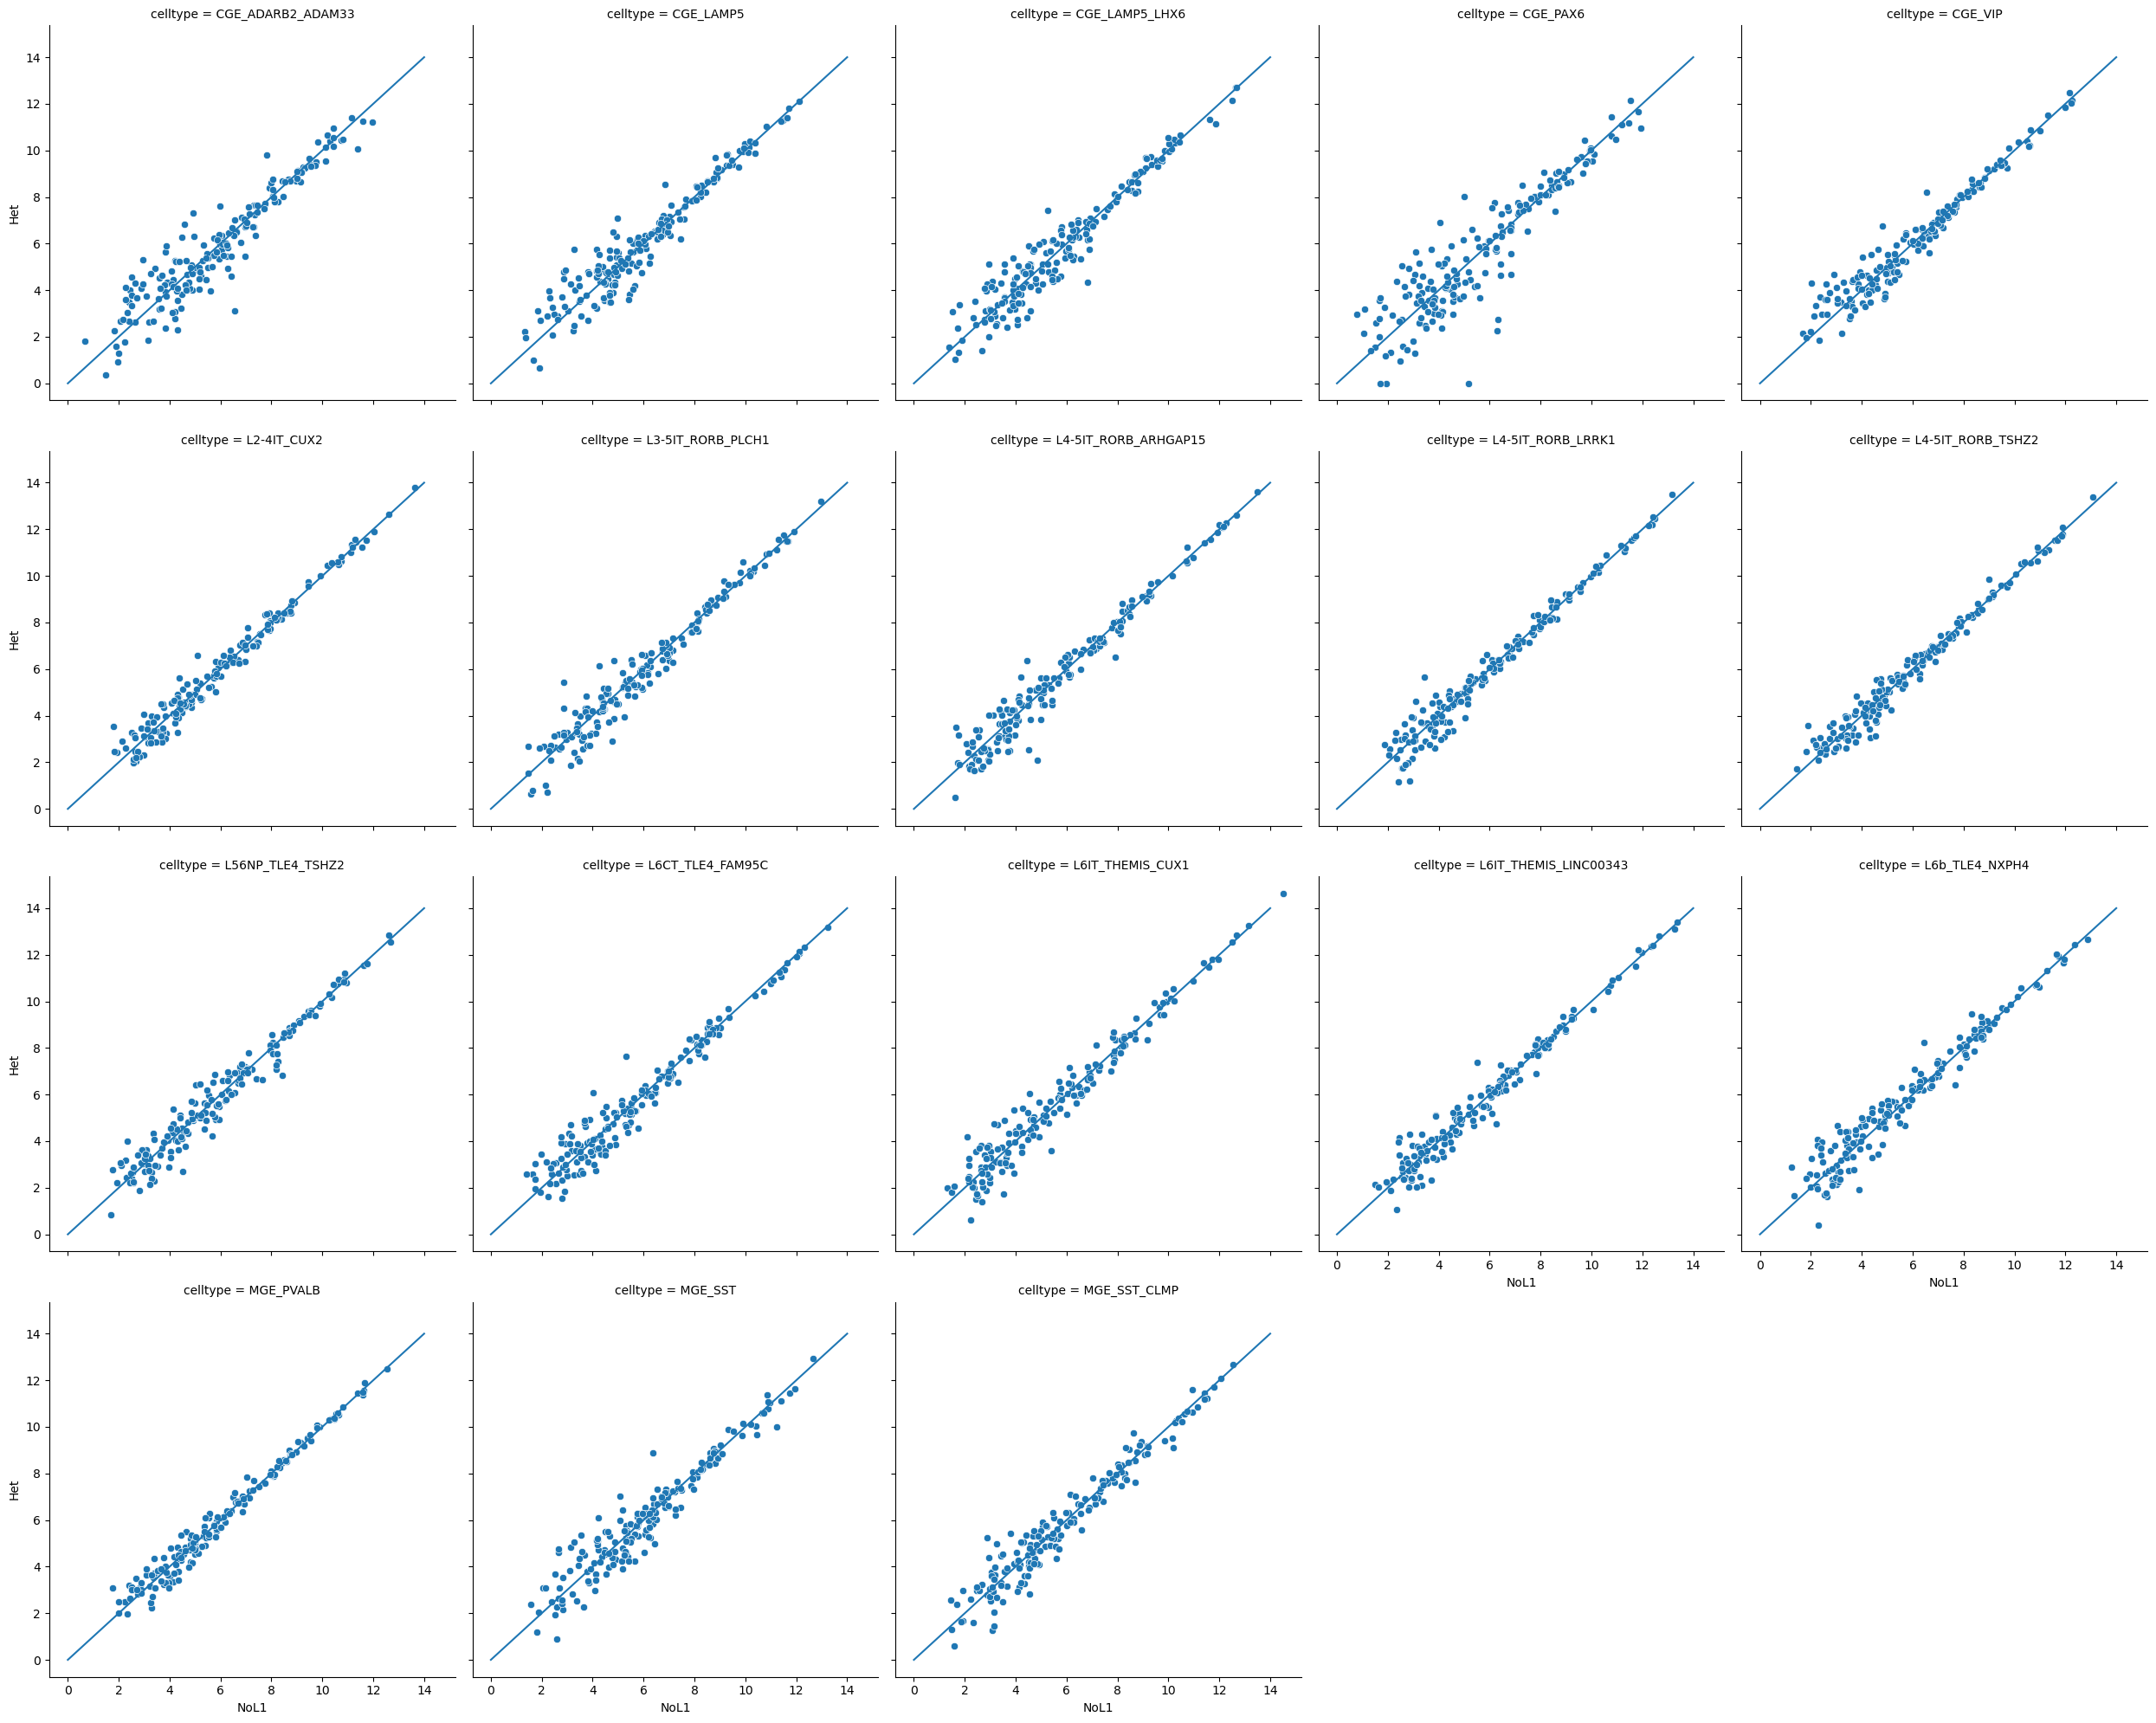

In [47]:
# Plot an overview of the data
g = sns.relplot(mean_cpm.unstack('genotype'), x=f'No{me_type}', y='Het', 
                col='celltype', col_wrap=5)

axes = g.axes.flatten()
for ax in axes:
    ax.plot([0,14], [0,14])

There doesn't appear to be a broad shift in average expression between the Het and NoME genotypes, but what we're interested in is individual differentially expressed genes. In order to find DEGs (i.e. run statistics), we must exclude genes overlapping unique MEVs that are present in only one sample.

In [48]:
def log2FC(x, y, axis):
    x_mean = np.mean(x, axis=axis)
    y_mean = np.mean(y, axis=axis)
    return x_mean - y_mean

In [49]:
cts = []
names = []
stats = []
pvalues = []

for idx, group in het_genes.groupby(['celltype','gene_name']):
    x = group[group['genotype'] == f'No{me_type}']['cpm']
    y = group[group['genotype'] == 'Het']['cpm']

    # Use permutation tests to determine whether a gene is differentially expressed
    try:
        res = permutation_test((x, y), log2FC, vectorized=True)
        stat, pval = res.statistic, res.pvalue
    except: # throw exception if a genotype group contains only one sample
        stat, pval = np.nan, np.nan

    cts.append(idx[0])
    names.append(idx[1])
    stats.append(stat)
    pvalues.append(pval)

permutation = pd.DataFrame({'celltype': cts, 'gene_name': names, 'statistic': stats, 'pvalue': pvalues})

In [50]:
permutation = permutation.dropna()
tested = permutation['gene_name'].unique()

permutation['gene_name'].nunique() # number of genes that were tested for differential expression

120

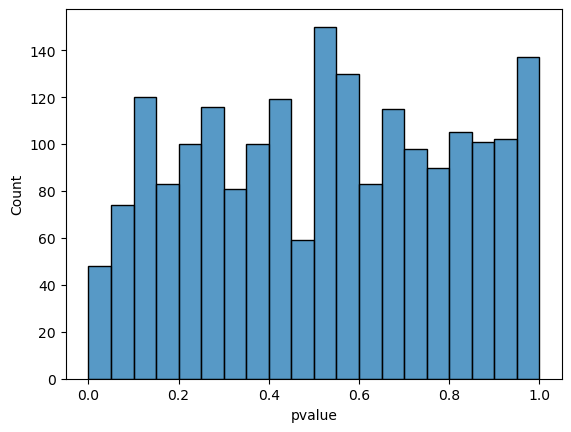

In [51]:
sns.histplot(permutation, x='pvalue', binwidth=0.05, binrange=(0,1));

A high rate of p-values below 0.05 suggests true differences. Otherwise, these values likely represent false positives and FDR correction will render them insignificant.

In [52]:
permutation['FDR'] = false_discovery_control(permutation['pvalue'])

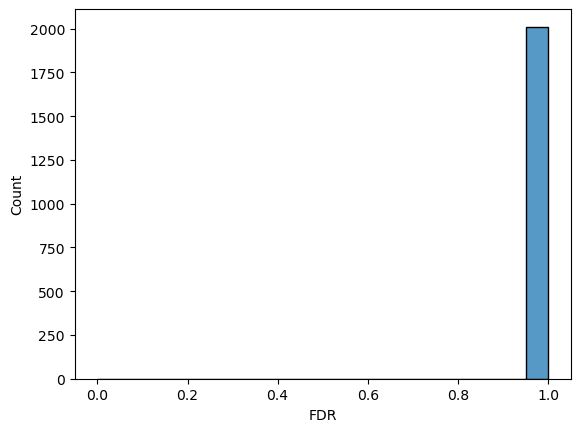

In [53]:
sns.histplot(permutation, x='FDR', binwidth=0.05, binrange=(0,1));

If there are no true DE genes, p-values values will be shifted towards 1 upon FDR correction.

## Plot RNA fold-change for MEV-gene pairs

In [78]:
test_genes = het_genes[het_genes['gene_name'].isin(tested)] # use only genes that were tested
mean_test_cpm = test_genes.groupby(['celltype','gene_name','genotype'])['cpm'].mean()

In [79]:
cpm_fc = mean_test_cpm.xs('Het', level='genotype') - mean_cpm.xs(f'No{me_type}', level='genotype') # log2FC

In [80]:
cpm_fc.index.get_level_values('gene_name').nunique() # TODO

1685

In [81]:
hm = cpm_fc.reset_index().pivot(index='gene_name', columns='celltype', values='cpm')
cols = np.loadtxt(celltypes, dtype=str)
hm = hm.dropna(how='all')

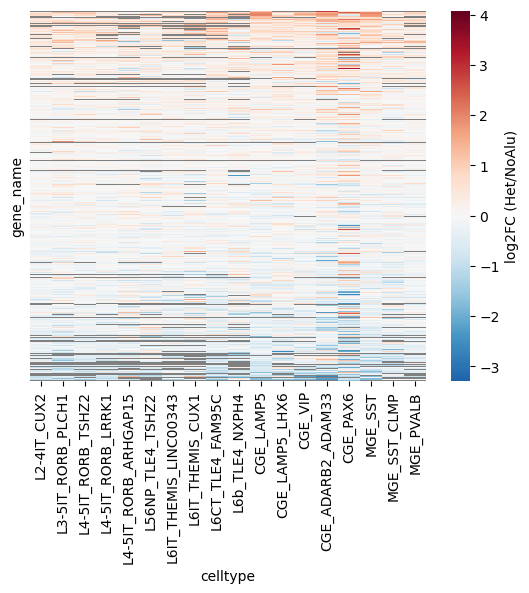

In [82]:
order = hm.mean(axis=1).sort_values(ascending=False).index
hm_ordered = hm.reindex(order)[cols]

ax = sns.heatmap(hm_ordered, xticklabels=True, yticklabels=False, center=0, cmap='RdBu_r', 
                 cbar_kws={'label': f'log2FC (Het/No{me_type})'})
ax.set_facecolor('grey');

In [83]:
hm_ordered.index[:20]

Index(['UGT2A1', 'UGT2A2', 'SCAMP1-AS1', 'ENSG00000253939', 'RERGL',
       'LINC02269', 'LINC01876', 'LRP2', 'DSG1-AS1', 'LINC02476', 'TMEM212',
       'ENSG00000251654', 'ENSG00000286425', 'LINC02336', 'LINC02825', 'SPTA1',
       'ENSG00000254631', 'LINC01416', 'ENSG00000233005', 'F13B'],
      dtype='object', name='gene_name')

## Correlate MEV methylation and gene expression

In [84]:
mc_cpm_info = gene_mc_cpm[['id','gene_name','gene_type','ctxt','celltype','sample','genotype','percent_mC','cpm']]

In [85]:
mc_cpm_info = mc_cpm_info[mc_cpm_info['gene_name'].isin(tested)]
mean_mc_cpm = mc_cpm_info.groupby(['gene_name','gene_type','ctxt','celltype','genotype'])[['percent_mC','cpm']].mean()

In [86]:
mc_cpm_fc = mean_mc_cpm.xs('Het', level='genotype') - mean_mc_cpm.xs(f'No{me_type}', level='genotype')
mc_cpm_fc = mc_cpm_fc.dropna()

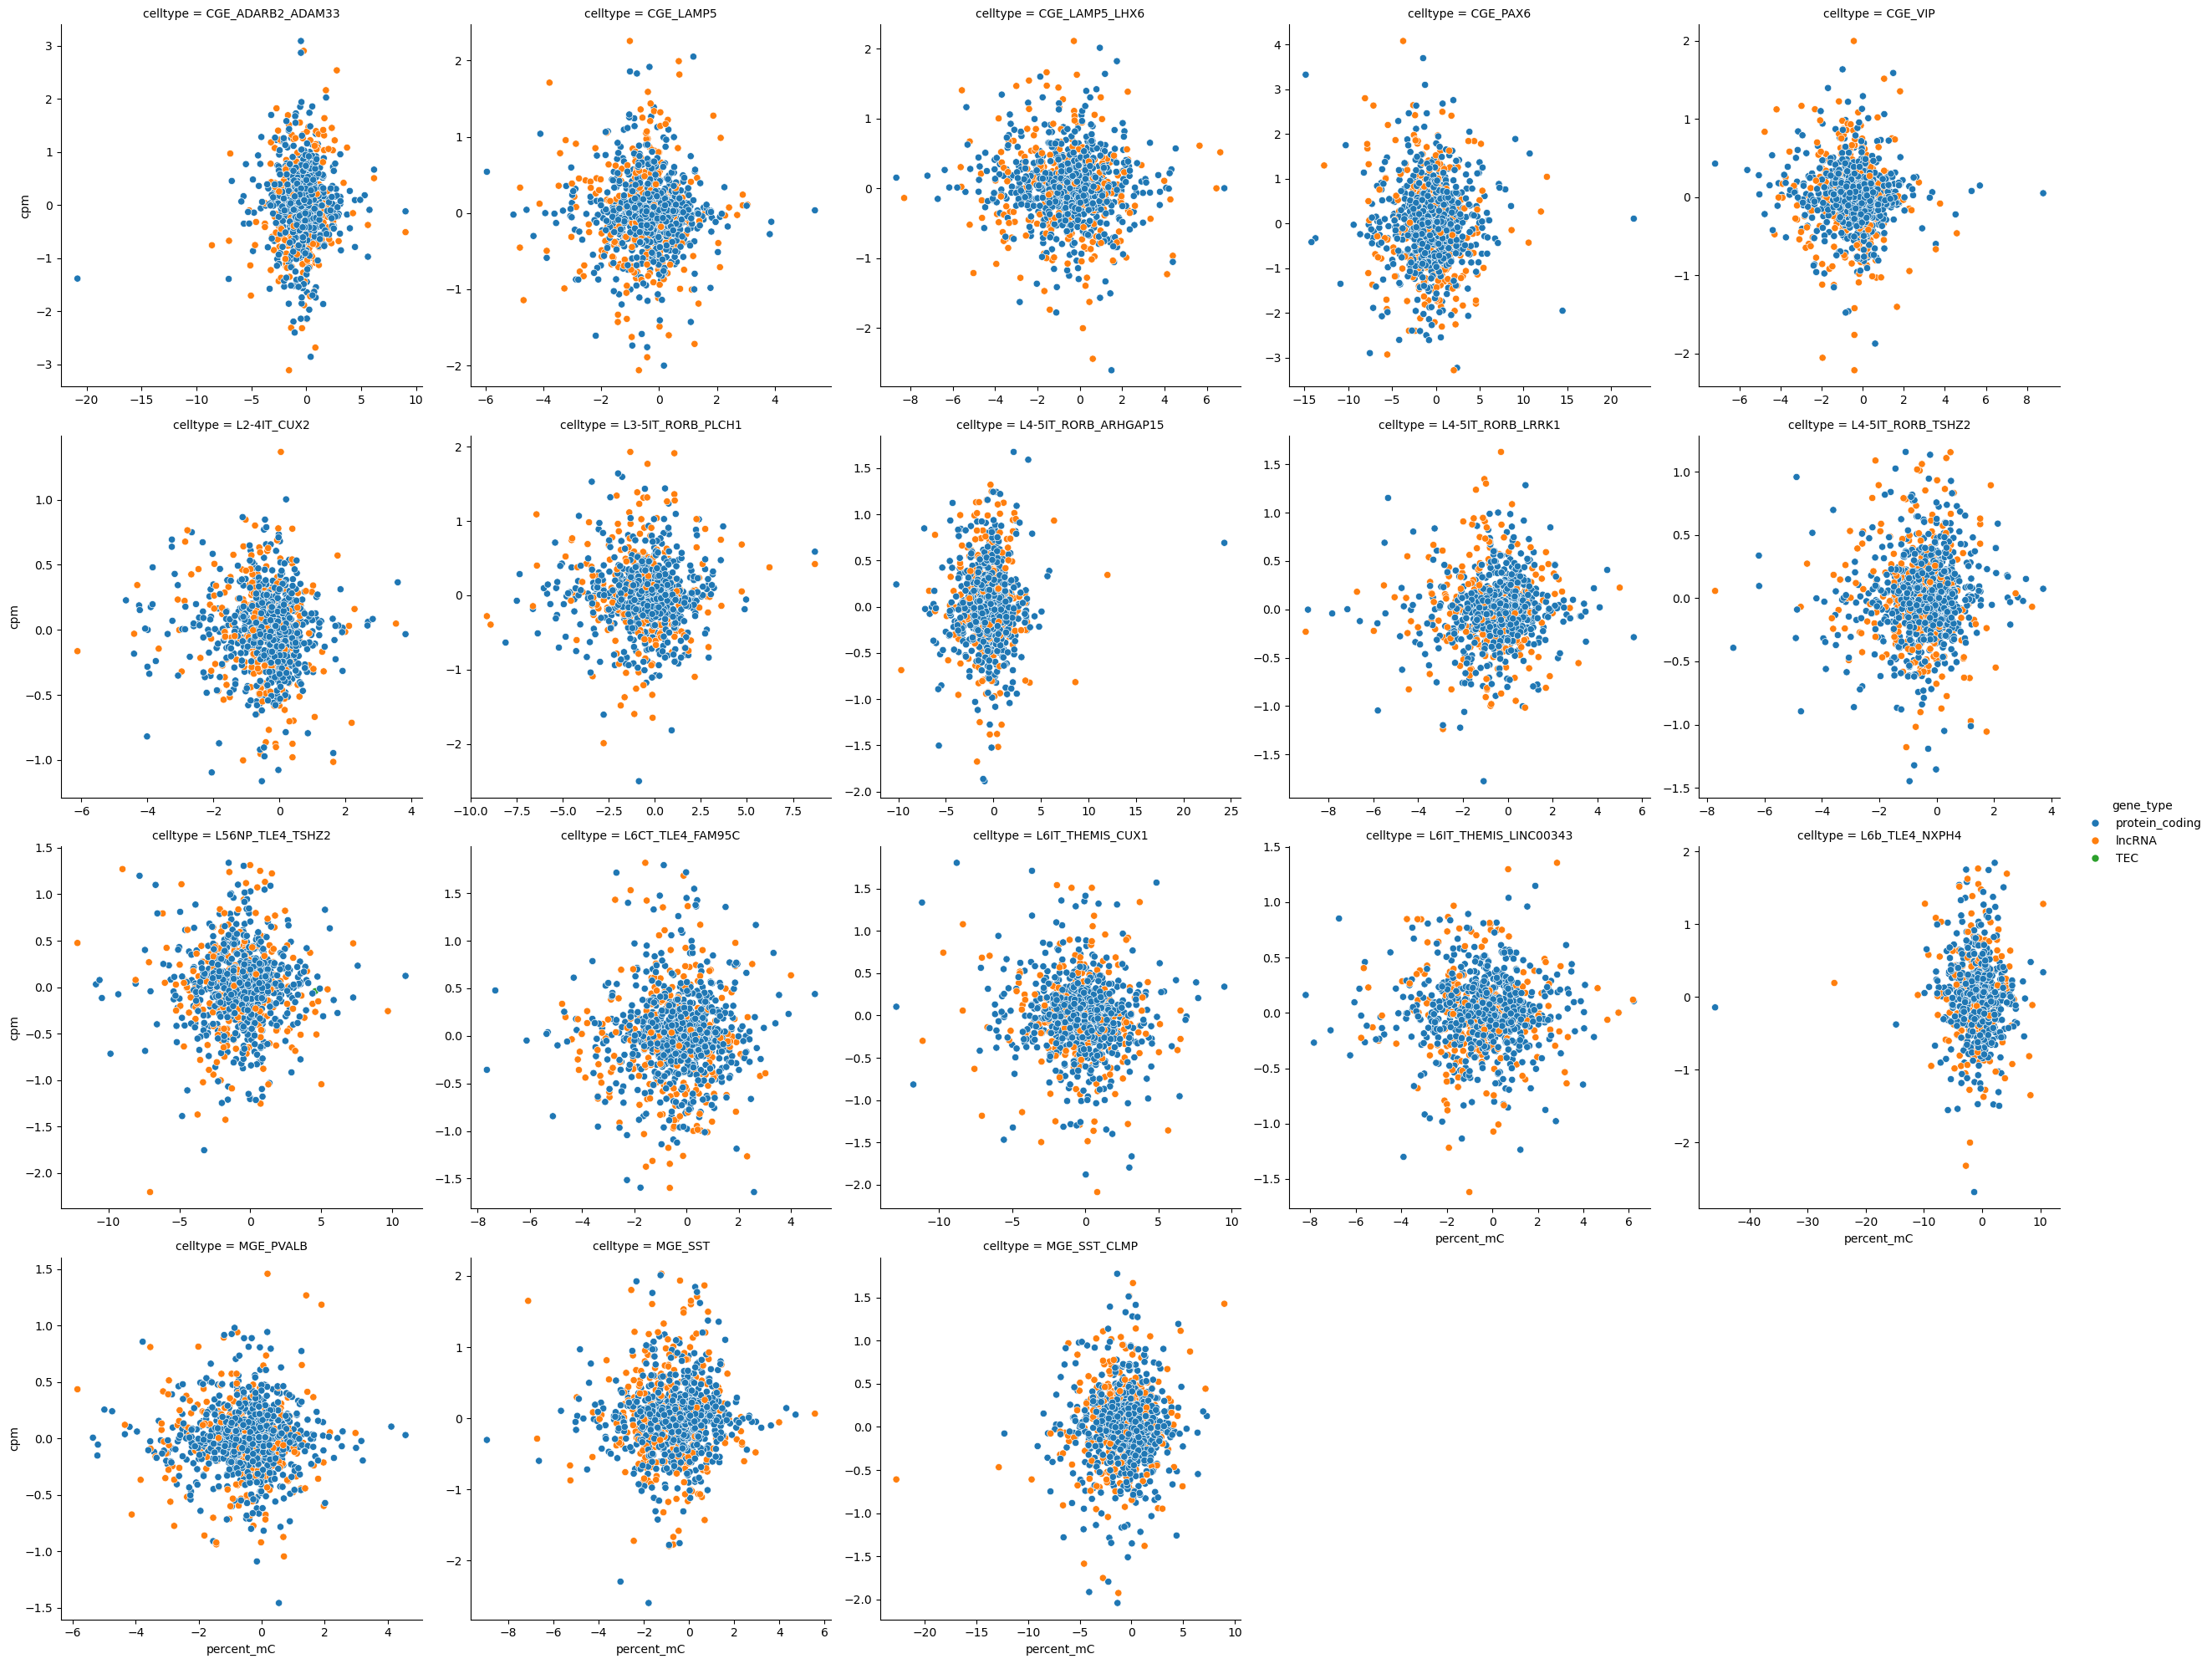

In [87]:
g = sns.relplot(mc_cpm_fc.xs('mCHN', level='ctxt'), x='percent_mC', y='cpm', 
                col='celltype', col_wrap=5, hue='gene_type',
                facet_kws={'sharex': False, 'sharey': False})

axes = g.axes.flatten()

In [88]:
for ct in cols:
    ct_df = mc_cpm_fc.xs('mCHN', level='ctxt').reset_index()
    ct_df = ct_df[ct_df['celltype'] == ct]
    corr = spearmanr(ct_df['percent_mC'], ct_df['cpm'])
    print(ct, ":", corr)

L2-4IT_CUX2 : SignificanceResult(statistic=-0.05484320684998087, pvalue=0.0847356826438394)
L3-5IT_RORB_PLCH1 : SignificanceResult(statistic=0.00602161894275596, pvalue=0.8476048300825048)
L4-5IT_RORB_TSHZ2 : SignificanceResult(statistic=0.05540828333593457, pvalue=0.07736594955924954)
L4-5IT_RORB_LRRK1 : SignificanceResult(statistic=0.06122195257096358, pvalue=0.05451152980904622)
L4-5IT_RORB_ARHGAP15 : SignificanceResult(statistic=-0.011471689931706039, pvalue=0.7219068016883681)
L56NP_TLE4_TSHZ2 : SignificanceResult(statistic=-0.009916097523307965, pvalue=0.7546138608081221)
L6IT_THEMIS_LINC00343 : SignificanceResult(statistic=0.0027947084337195324, pvalue=0.9310862639527934)
L6IT_THEMIS_CUX1 : SignificanceResult(statistic=-0.0760308344473642, pvalue=0.01986719244952198)
L6CT_TLE4_FAM95C : SignificanceResult(statistic=0.018679931276498214, pvalue=0.5506492820706549)
L6b_TLE4_NXPH4 : SignificanceResult(statistic=-0.07126413998310505, pvalue=0.025838752431309408)
CGE_LAMP5 : Significa